Script based on https://albertoacerbi.github.io/IBM-cultevo/rogers-paradox.html

With added comments and some modifications by OM & AB

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## A. Building the model

### A1. Initialise the population

#### Create a population of *N* individuals

*N*, the pop size, is a parameter whose value will be specified later. "learning" indicates the learning strategy of each individual.  
When the simulation starts, everyone is an individual learner, so learning = "individual", as opposed to "social".  

In [2]:
def initialise_population(N):
    """A1. Initialise the population and environment."""
    population = pd.DataFrame({
        "learning": ["individual"] * N,
        "behavior": [np.nan] * N,
        "fitness": [np.nan] * N,
    })
    return population

Let's assume that *N* = 1000 for now.

In [3]:
N = 1000
population = initialise_population(N)
population.head()

learning  behavior  fitness
0  individual       NaN      NaN
1  individual       NaN      NaN
2  individual       NaN      NaN
3  individual       NaN      NaN
4  individual       NaN      NaN

### A2. Social learning learn from others

This part models the behavior of social learners: the individuals who have a "social" learning strategy.  
  
It only runs if the number of social learners in the population is not null.  
Since we start from a population of 100% individual learners, this won't run for the 1st generation.  
  
We extract the social learners from the population, and we make each one of them sample a random number of individuals from the previous population, and inherit their value for "behavior".

In [4]:
def social_learning(population, previous_population):
    mask_social = population["learning"] == "social"
    n_social = mask_social.sum()
    
    population.loc[mask_social, "behavior"] = np.random.choice(
        previous_population["behavior"].values,
        size=n_social,
        replace=True
    )
    return population

In [5]:
N = 1000

# We initalize the previous population with random value of behaviour
previous_population = initialise_population(N)
previous_population["behavior"] = np.random.choice([0, 1], size = N)

# We assign the current population random learning strategies
current_population = initialise_population(N)
current_population["learning"] = np.random.choice(["individual", "social"], size = N)

# We test the function
population = social_learning(current_population, previous_population)
population.head()

learning  behavior  fitness
0  individual       NaN      NaN
1  individual       NaN      NaN
2      social       0.0      NaN
3  individual       NaN      NaN
4      social       0.0      NaN

### A3. Individual learners learn to match their behavior to the environment  

This models the behavior of individual learners.  
  
These individuals match their behavior to the environment (*E*) with probability *p*.  
  
The behavior matches the environment when the corresponding integers are identical: in this case, learning is "correct".

In [6]:
def individual_learning(population, E, p):
    """A3. Individual learners try to match behavior to environment with probability p."""
    N = len(population)
    learn_correct = np.random.choice(
        [True, False],
        size = N,
        p = [p, 1 - p]
    )

    # This line picks all the individuals who are individual learners
    mask_individual = population["learning"] == "individual"

    # # This line picks all the individuals who are individual learners and has just been
    # tagged as "learn_correct = TRUE", and it matches their behavior to the environment.
    mask_correct = learn_correct & mask_individual
    population.loc[mask_correct, "behavior"] = E

    # This line does the opposite with individual learners who were tagged as 
    # learn_correct = FALSE. 
    # It makes them learn the wrong behavior, a behavior that is different from E,
    # and so does not match the environment.
    mask_incorrect = (~learn_correct) & mask_individual
    population.loc[mask_incorrect, "behavior"] = E - 1

    return population

The nature of the environment (*E*) is represented by an integer.  
The numeric value of the integer doesn't actually matter; we just use it to say whether two environments are the same or are different.  
Let's assume *E* = 0 and *p* = 0.5

In [7]:
E = 0
p = 0.5
N = 1000

population = initialise_population(N)
# We assign the current population random learning strategies
population["learning"] = np.random.choice(["individual", "social"], size = N)

individual_learning(population, E, p)

learning  behavior  fitness
0    individual       0.0      NaN
1    individual      -1.0      NaN
2    individual       0.0      NaN
3        social       NaN      NaN
4    individual      -1.0      NaN
..          ...       ...      ...
995  individual       0.0      NaN
996  individual       0.0      NaN
997      social       NaN      NaN
998  individual       0.0      NaN
999      social       NaN      NaN

[1000 rows x 3 columns]

### A4. Fitness is assigned to social and individual learners

Fitness is assigned to individuals in 3 steps:  
  1. Deal everyone the baseline *w* value  
  2. Grant or subtract benefit *b* to those whose behavior matches the environment  
  3. Subtract the costs of learning.  
  
We need a baseline for fitness: that is, a default value that is assigned to every individual before any change is made.  
  
Note : small *w* is the default value for fitness, not to be confounded with the population's average fitness, capital *W*.  
  
To compute fitness and adjust it to learning strategies, we need 3 more variables:  
  1. *b* : benefit of having a behaviour that match the environment *E*.  
  2. *c* : the cost of individual learning.  
  3. *s* : the cost of social learning.  

Learning cost (both *c* and *s*) depends on the possible gains (or losses) of accurate (or inaccurate) learning.  
  
Note : the value of *c* and *s* can be different.

In [8]:
def assign_fitness(population, E, w, b, c, s):
    """A4. Assign fitness to individuals based on behavior and learning strategy."""

    # Assign the default value for fitness
    population["fitness"] = w

    # Benefit or cost depending on match with environment
    mask_match = population["behavior"] == E
    mask_mismatch = population["behavior"] != E

    population.loc[mask_match, "fitness"] += b
    population.loc[mask_mismatch, "fitness"] -= b

    # Cost of individual learning
    mask_individual = population["learning"] == "individual"
    population.loc[mask_individual, "fitness"] -= b * c

    # Cost of social learning
    mask_social = population["learning"] == "social"
    population.loc[mask_social, "fitness"] -= b * s

    return population

*w* is hard-coded to 1, an arbitrary value.  
Let's assume that:  
- *b* = 0.5
- *c* = 0.8
- *s* = 0

Initialise the population with random value for learning and behaviour, and *w* for fitness.

In [9]:
N = 1000
w = 1.0

population = initialise_population(N)
population["learning"] = np.random.choice(["individual", "social"], size = N)
population["fitness"] = [w] * N
population["behavior"] = np.random.choice([0, 1], size = N)
population.head()

learning  behavior  fitness
0      social         1      1.0
1      social         0      1.0
2  individual         0      1.0
3  individual         1      1.0
4      social         0      1.0

Test the *assign_fitness* function.

In [10]:
E = 0
b = 0.5
c = 0.8
s = 0

assign_fitness(population, E, w, b, c, s)

learning  behavior  fitness
0        social         1      0.5
1        social         0      1.5
2    individual         0      1.1
3    individual         1      0.1
4        social         0      1.5
..          ...       ...      ...
995      social         1      0.5
996      social         1      0.5
997      social         0      1.5
998      social         1      0.5
999      social         0      1.5

[1000 rows x 3 columns]

Note: Multiplying c and s by b is a nicety, but the model works roughly the same without it.

### A5. Indidividuals reproduce according to their fitness

We know what we wanted to know about the current generation.  
It's time to wipe it out and get a new one.  
Which individuals will reproduce and spawn the next generation ?  
This depends on individual fitness values.  
Importantly, each individual's offspring will inherit its parent's social learning strategy, unless a mutation occurs.  
  
First, we compute the individual learners (IL) fitness compared to the overall population.  
  
Note : IL fitness = 0 if no one learns individually

In [11]:
def compute_IL_fitness(population):
    mask_individual = population["learning"] == "individual"
    total_fitness = population["fitness"].sum()

    if mask_individual.sum() > 0 and total_fitness > 0:
        IL_fitness = population.loc[mask_individual, "fitness"].sum() / total_fitness
    else:
        IL_fitness = 0.0

    return IL_fitness

Then, we draw the new learning strategies based on fitness.

In [12]:
def draw_learning_strategies(N, IL_fitness):
    return np.random.choice(
        ["individual", "social"],
        size = N,
        p = [IL_fitness, 1 - IL_fitness]
    )

Then, we initialise a new population with specific learning strategies.  
In the new generation, the proportion of individual learners will be proportional to their relative fitness in the previous generation.

In [13]:
def initialise_new_population(learning_new):
    N = len(learning_new)
    return pd.DataFrame({
        "learning": learning_new,
        "behavior": [np.nan] * N,
        "fitness": [np.nan] * N,
    })

Finally, we apply mutation to learning stratagies with probability *mu*.  
When a mutation occurs, it turns individual learners into social, and vice versa.

In [14]:
def mutate_learning(population, mu):
    mutation = np.random.choice([True, False], size = len(population), p = [mu, 1 - mu])
    
    # We save the previous population learning strategy
    learning_before = population["learning"].copy()

    mask_indiv_mut = (learning_before == "individual") & mutation
    mask_soc_mut = (learning_before == "social") & mutation

    population.loc[mask_indiv_mut, "learning"] = "social"
    population.loc[mask_soc_mut, "learning"] = "individual"

    return population

Now, we combine every function to make the reproduction function.

In [15]:
def reproduce(population, N, mu):

    # We save the previous population
    previous_population = population.copy()

    # Compute the fitness
    IL_fitness = compute_IL_fitness(previous_population)

    # Get the learning strategies
    learning_new = draw_learning_strategies(N, IL_fitness)

    # Initialise the new population
    population = initialise_new_population(learning_new)

    # Apply mutation to the new population
    population = mutate_learning(population, mu)

    return population, previous_population


We re-use some code from A4. to initialise our *previous_population*, then test the *reproduce* function.

In [16]:
N = 1000
w = 1.0
E = 0
b = 0.5
c = 0.8
s = 0

previous_population = initialise_population(N)
previous_population["learning"] = np.random.choice(["individual", "social"], size = N)
previous_population["fitness"] = [w] * N
previous_population["behavior"] = np.random.choice([0, 1], size = N)
previous_population.head()
previous_population = assign_fitness(previous_population, E, w, b, c, s)
previous_population.head()

learning  behavior  fitness
0  individual         1      0.1
1  individual         1      0.1
2  individual         1      0.1
3      social         1      0.5
4      social         1      0.5

Let's assume *mu* = 0.01.  

In [17]:
mu = 0.01

new_population, _ = reproduce(previous_population, N, mu)

new_population.head()

learning  behavior  fitness
0  individual       NaN      NaN
1  individual       NaN      NaN
2      social       NaN      NaN
3      social       NaN      NaN
4  individual       NaN      NaN

### A6. Change of environment

At each timestep / generation, the environment may change, with probability *u*.  
If it does, then the behavior that matched the environment in the previous generation no longer will: its fitness will be negative instead of positive.

In [18]:
def env_change(E, u):
    if np.random.rand() < u:
        E = E + 1
    return E

Let's assume *u* = 0.2 and test the function *env_change*

In [19]:
E = 0
u = 0.2

# Let's decide the number of test we will run and create a way to save data
n = 1000
data = []

# We run the function n time
for i in range(n):
    data.append(env_change(E, u))

# print the first 10 values of data
print(data[:10])

# Print the percentage of time the environment change. If the function runs correctly,
# this value should get closer to u we larger n
print(sum(data)/n * 100)

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1]
19.400000000000002


## B. Running the model

Now that we have all building blocks for the model, we can run it properly with a single function.

In [20]:
def rogers_model(N, t_max, r_max, 
                 w=1.0, b=0.5, c=0.9, s=0.0, mu=0.01, p=1.0, u=0.2):
    """
    Python translation of Rogers' model.

    Parameters mirror the R version:
    - N: population size
    - t_max: number of generations per run
    - r_max: number of runs
    - w: baseline fitness
    - b: benefit of matching environment (and cost of mismatch)
    - c: cost multiplier for individual learning
    - s: cost multiplier for social learning
    - mu: mutation probability of learning strategy
    - p: probability individual learners learn correctly
    - u: probability of environmental change per generation
    """

    # Initialise the environment
    E = 0

    # Parameter check to avoid negative fitness
    if b * (1 + c) > 1 or b * (1 + s) > 1:
        raise ValueError("Invalid parameter values: ensure b*(1+c) < 1 and b*(1+s) < 1")


    # Prepare output DataFrame
    generations = np.tile(np.arange(1, t_max + 1), r_max)
    runs = np.repeat(np.arange(1, r_max + 1), t_max)

    # Create output dataframe
    output = pd.DataFrame({
        "generation": generations,
        "run": runs.astype(str),
        "p_SL": np.nan,
        "W": np.nan,
    })

    # Main simulation
    for r in range(1, r_max + 1):
        population = initialise_population(N)
        previous_population = None

        for t in range(1, t_max + 1):
            # A2. Social learning
            if previous_population is not None: # first generation: nothing to copy
                population = social_learning(population, previous_population)

            # A3. Individual learning
            population = individual_learning(population, E, p)
            
            # A4. Fitness assignment
            population = assign_fitness(population, E, w, b, c, s)

            # Store summary stats
            mask = (output["generation"] == t) & (output["run"] == str(r))
            output.loc[mask, "p_SL"] = (population["learning"] == "social").mean()
            output.loc[mask, "W"] = population["fitness"].mean()

            # A5. Reproduction
            population, previous_population = reproduce(population, N, mu)

            # A6. Environment change
            E = env_change(E, u)

    return output

And now we can run the model !  
We will use Acerbi et. al.'s values at first :

In [21]:
data_model = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

data_model.head()

generation run   p_SL        W
0           1   1  0.000  1.05000
1           2   1  0.011  1.05495
2           3   1  0.023  1.06035
3           4   1  0.044  1.02580
4           5   1  0.028  1.06060

Note : An explanation for every parameters can be found in the function description.

## C. Visualising results

### Plot of the proportion of social learners over time.

In [22]:
def plot_multiple_runs_p_SL(data_model):
    plt.figure(figsize=(10, 6))

    # Plot each run
    for run_id, df_run in data_model.groupby("run"):
        plt.plot(df_run["generation"], df_run["p_SL"], alpha=0.4, label=f"run {run_id}")

    # Plot mean across runs
    mean_p_SL = data_model.groupby("generation")["p_SL"].mean()
    plt.plot(mean_p_SL.index, mean_p_SL.values, color="black", linewidth=2, label="mean")

    plt.ylim(0, 1)
    plt.xlabel("generation")
    plt.ylabel("proportion of social learners")
    plt.title("Proportion of social learners over time")
    plt.tight_layout()
    plt.show()

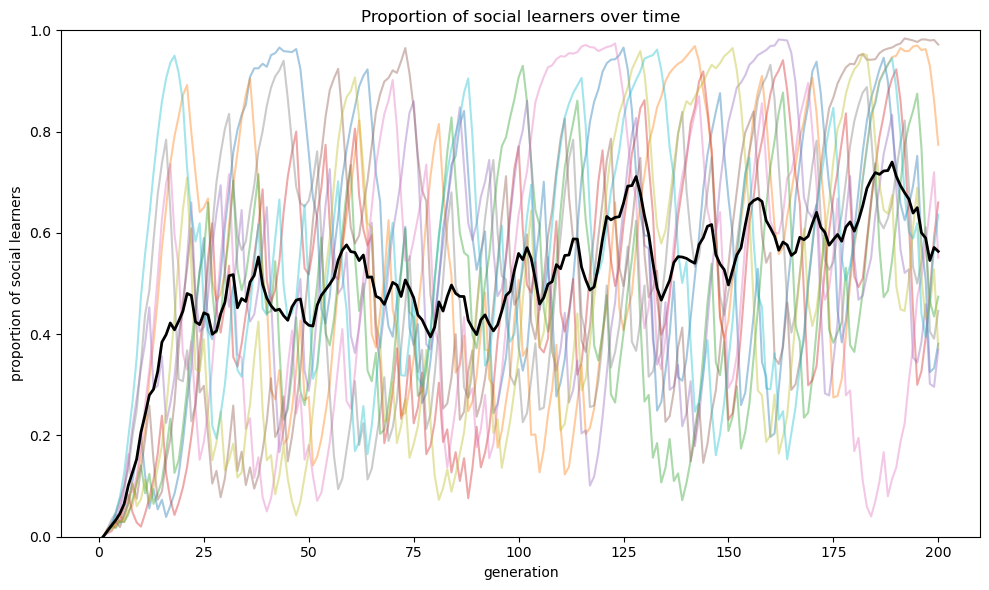

In [23]:
plot_multiple_runs_p_SL(data_model)

### Plot of the average fitness of the population over time.  
  
The dotted line correspond to the fitness of individual learning, equal to :  
$$
w + b * (2 * p - c - 1)
$$  
with :  
- *w* : baseline fitness value  
- *b* : benefit of matching the environment  
- *p* : probability of matching the environment  
- *c* : costs of social learning  

In [24]:
def plot_W(data_model, w=1.0, b=0.5, c=0.9, p=1.0):
    plt.figure(figsize=(10, 6))

    # Plot each run
    for run_id, df_run in data_model.groupby("run"):
        plt.plot(df_run["generation"], df_run["W"], alpha=0.4, label=f"run {run_id}")

    # Plot mean across runs
    mean_W = data_model.groupby("generation")["W"].mean()
    plt.plot(mean_W.index, mean_W.values, color="black", linewidth=2, label="mean")

    # Theoretical fitness of individual learning
    y_theoretical = w + b * (2 * p - c - 1)
    plt.axhline(y=y_theoretical, linestyle="--", color="red", label="individual learning fitness")

    plt.ylim(bottom=0)
    plt.xlabel("generation")
    plt.ylabel("mean population fitness")
    plt.title("Mean population fitness over time")
    plt.tight_layout()
    plt.show()

Don't forget to change the value of *w*, *b*, *c* and *p* if you changed them in the model !

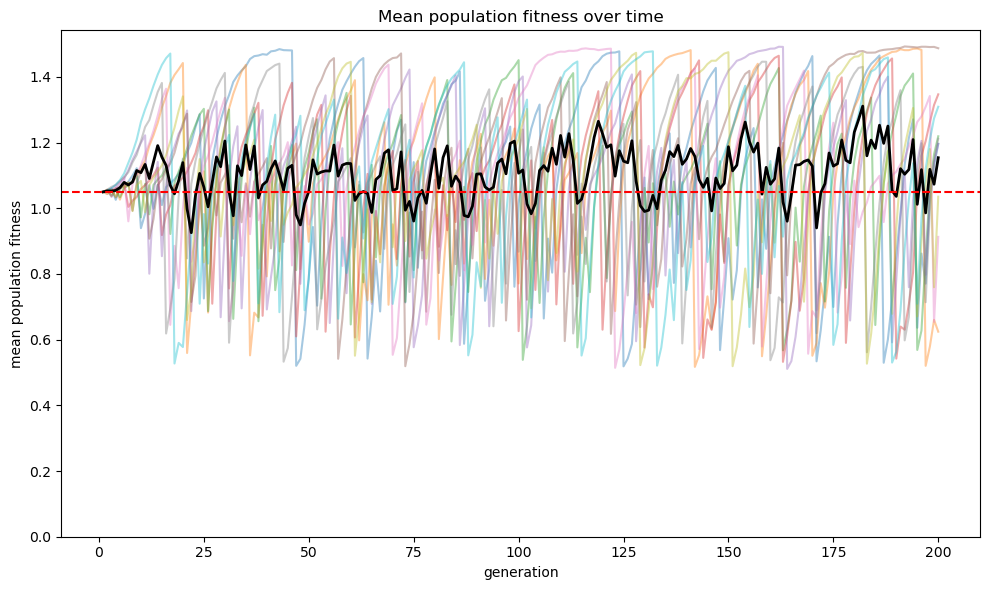

In [25]:
plot_W(data_model, w=1.0, b=0.5, c=0.9, p=1.0)

# Correction

### 1. What happens when the costs of individual learning become smaller?

#### Intuition

Reducing the cost of individual learning should increase the proportion of individual learners.

To test this, we run the model with 3 values of *c*, store and plot the results.

In [ ]:
data_model_low_cost_IL = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.2,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

data_model_medium_cost_IL = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.5,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

data_model_high_cost_IL = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

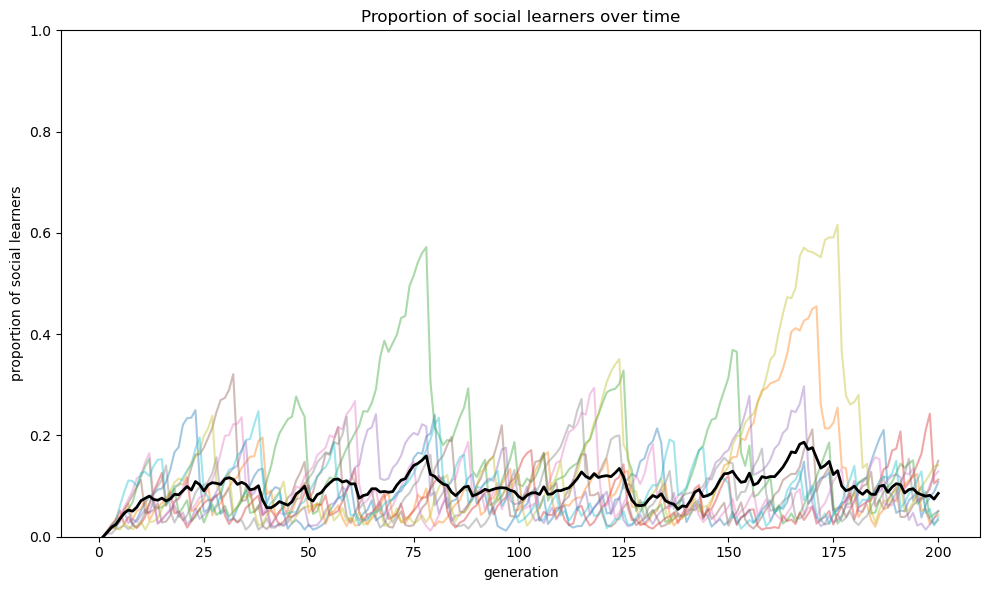

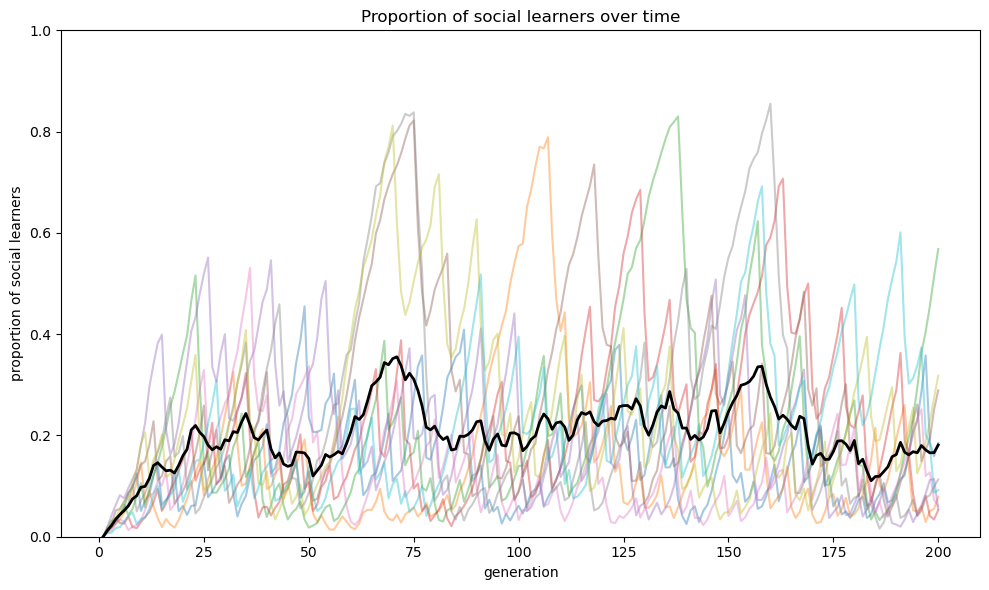

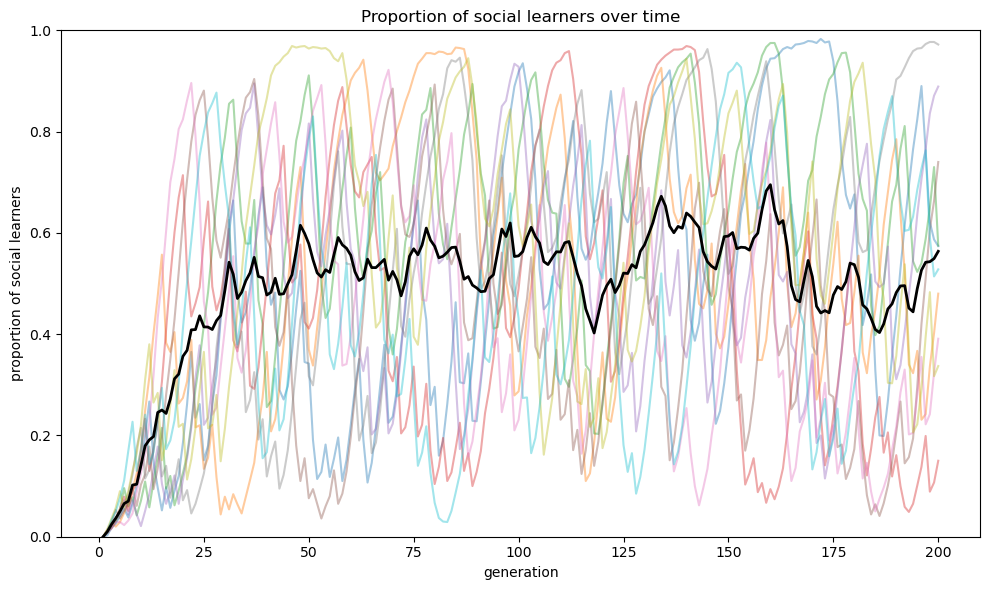

In [ ]:
plot_multiple_runs_p_SL(data_model_low_cost_IL)
plot_multiple_runs_p_SL(data_model_medium_cost_IL)
plot_multiple_runs_p_SL(data_model_high_cost_IL)

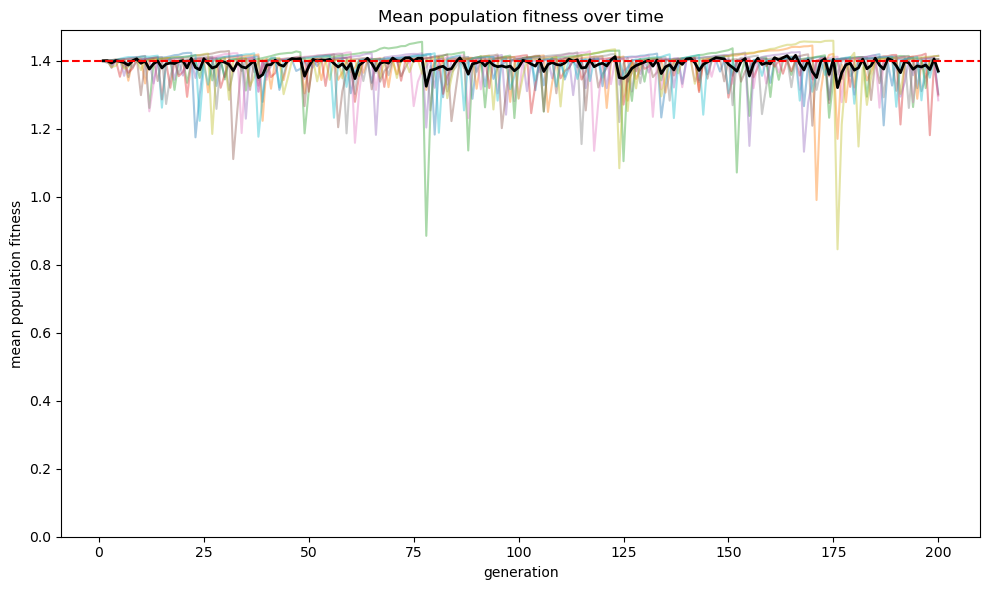

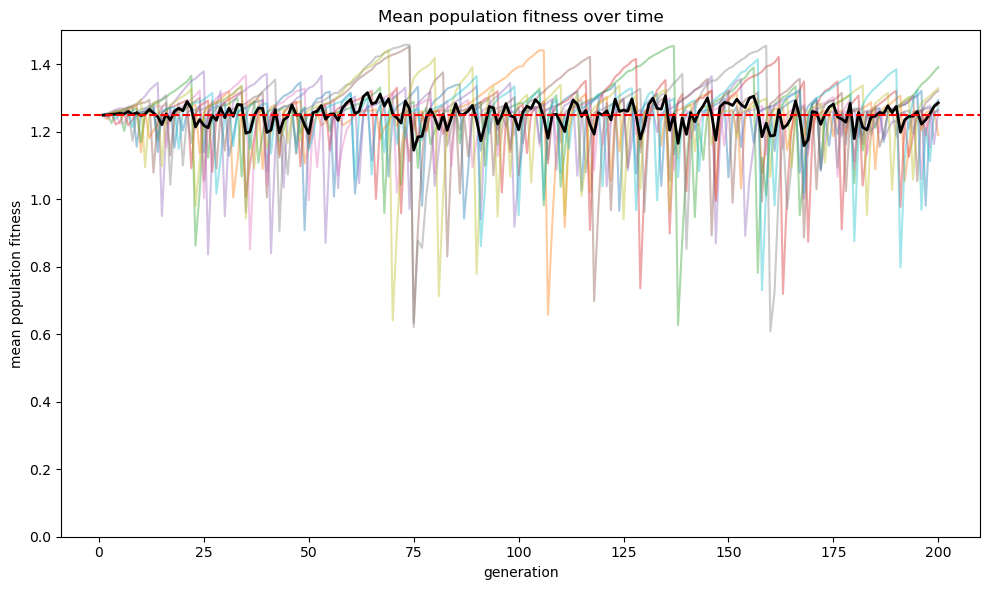

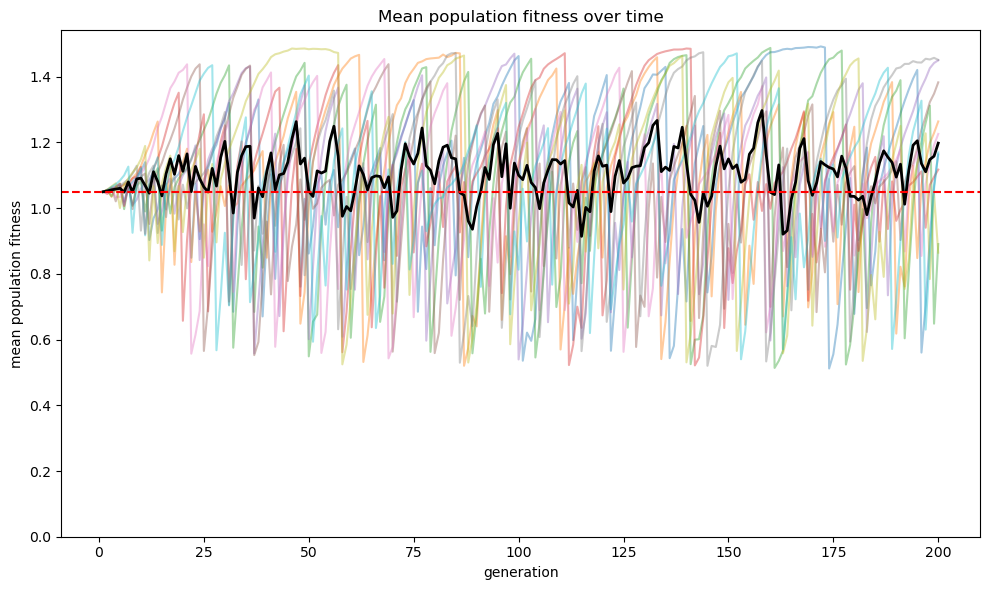

In [ ]:
plot_W(data_model_low_cost_IL, w=1.0, b=0.5, c=0.2, p=1.0)
plot_W(data_model_medium_cost_IL, w=1.0, b=0.5, c=0.5, p=1.0)
plot_W(data_model_high_cost_IL, w=1.0, b=0.5, c=0.9, p=1.0)

#### Answer

We see that lower cost of individual learning results in less social learners.

However, it doesn't change the fact that the population fitness is equal the fitness of a population with only individual learner (the red-dotted line).

We are still under Roger's paradox!

### 2. In the model’s basic version, p = 1, meaning the efficiency of individual learning is perfect. How does the evolution of social learning change, if p is lower?

#### Intuition

Reducing p should reduce the benefit of individual learning. This should lead to an increase of social learning, and maybe a decrease of the population fitness.

To test this, we run the model with 3 values of *p*, store and plot the results.

In [31]:
data_model_low_p = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=0.2,
    u=0.2
)

data_model_medium_p = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=0.5,
    u=0.2
)

data_model_base_p = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

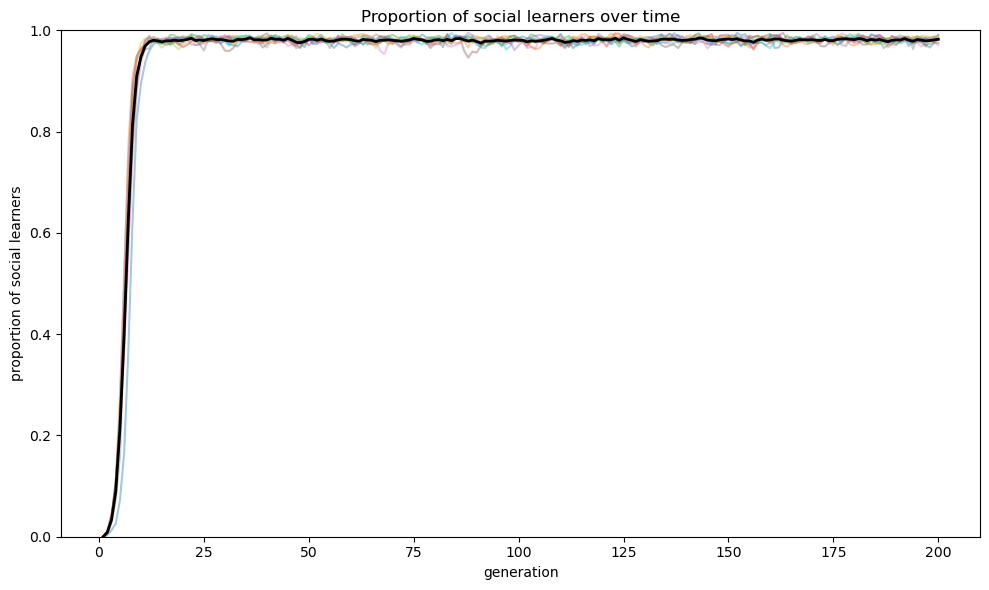

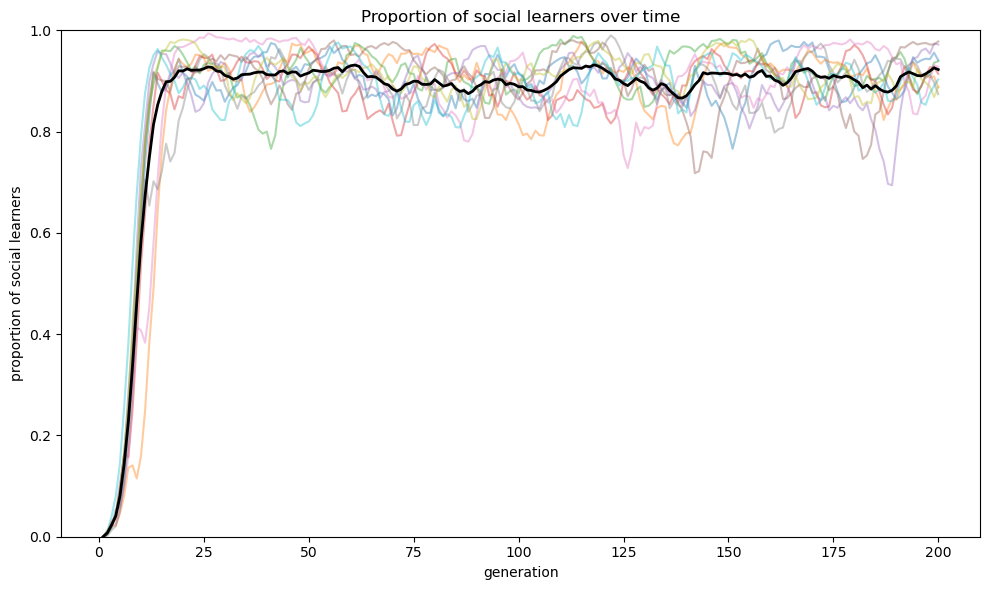

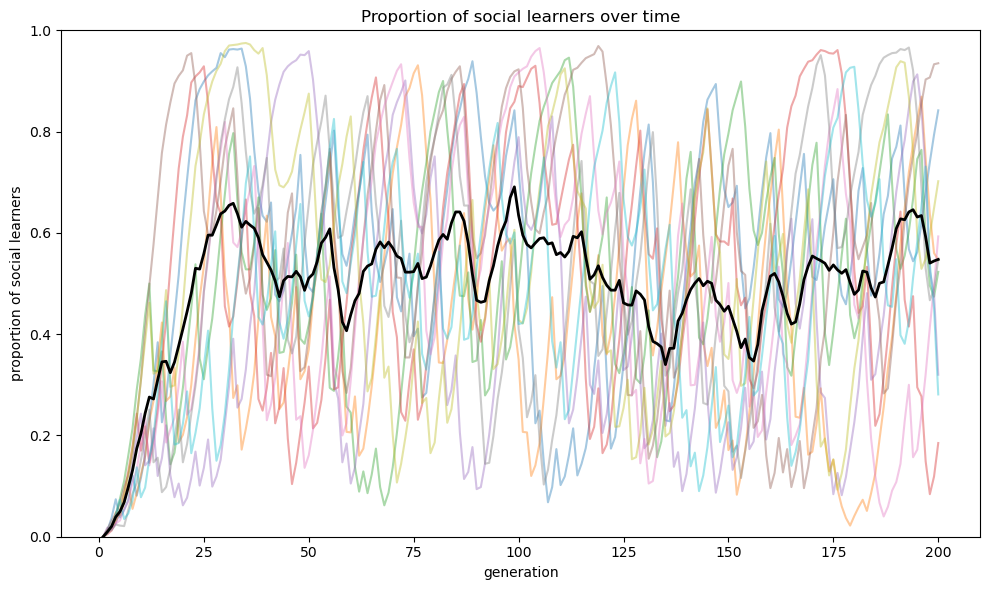

In [32]:
plot_multiple_runs_p_SL(data_model_low_p)
plot_multiple_runs_p_SL(data_model_medium_p)
plot_multiple_runs_p_SL(data_model_base_p)

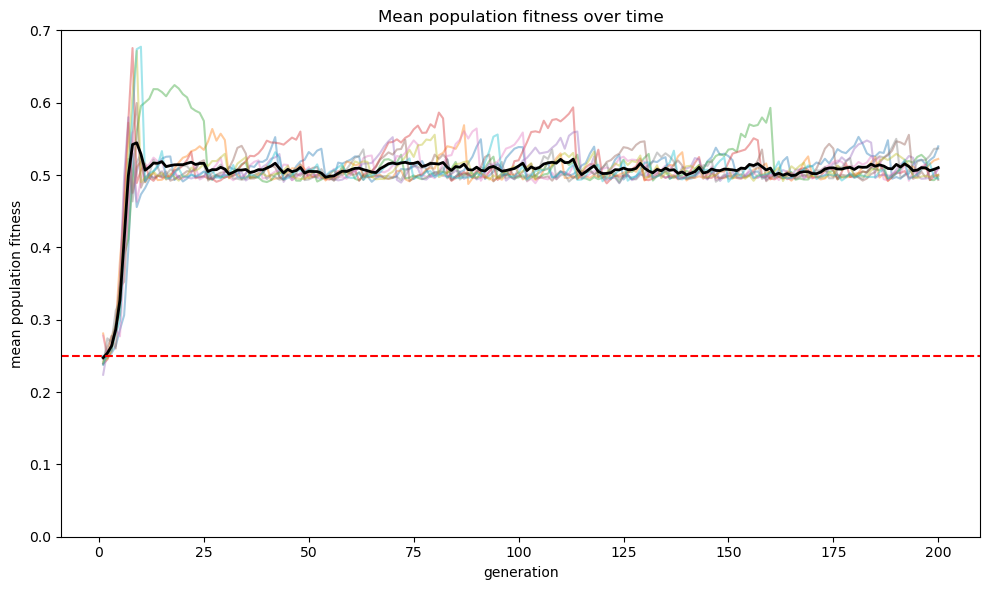

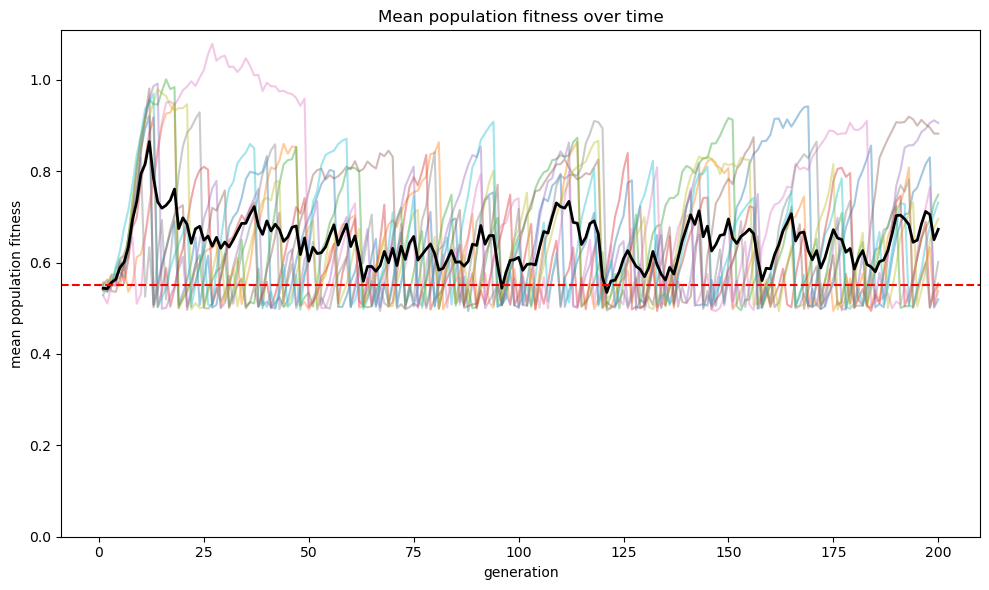

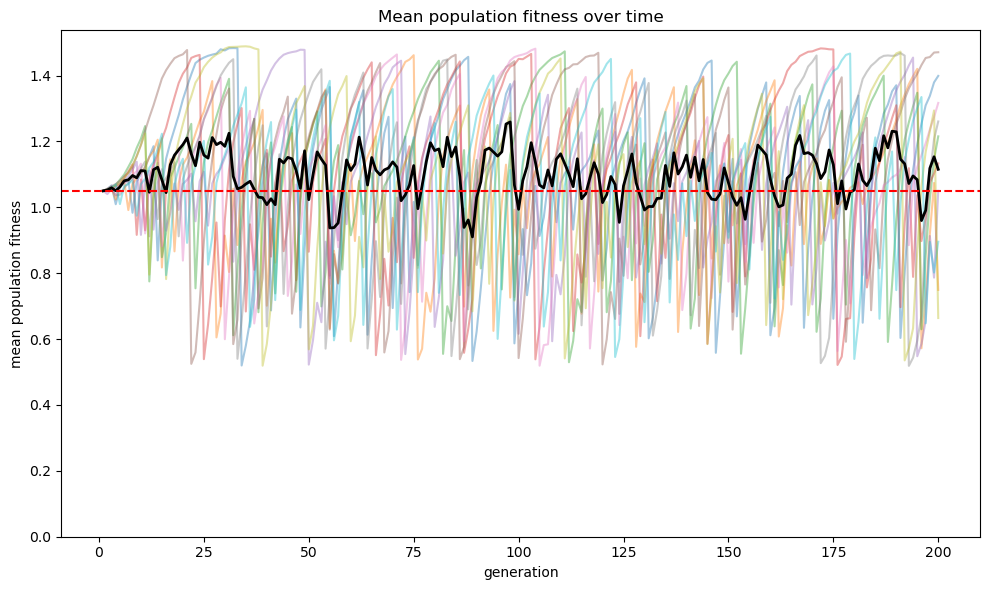

In [34]:
plot_W(data_model_low_p, w=1.0, b=0.5, c=0.9, p=0.2)
plot_W(data_model_medium_p, w=1.0, b=0.5, c=0.9, p=0.5)
plot_W(data_model_base_p, w=1.0, b=0.5, c=0.9, p=1.0)

#### Answer

The number of social learning does increase, certainly because individual learning is less reliable now.

However, the population fitness is better than the theoretical fitness of an individual learner only population. This results can be explained by the fact that with low *p*, individual learning is too inconsistent. It is then better to just learn socially information, eventhough they're all outdated/wrong. If we look more closely at the y-axis of the first plot, we see that the population fitness is ~ 0.5, much lower than all over model we ran thus far. This means that while with low *p* social learning might evolve, it will lead to a population unfit less fit to their environment than a population with higher *p* and no social learners.

### 3. What happens to Rogers' paradox when the environment does not change at all?

#### Intuition

If the environment doesn't change, the population will converge quickly on the right behavior, rendering individual learning useless.

Thus, we expect a lower number of individual learner, and maybe a better population fitness.

To test this, we run the model with 2 values of *u*, the base one and *u = 0*.

In [35]:
data_model_environmental_change = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

data_model_no_environmental_change = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.0
)

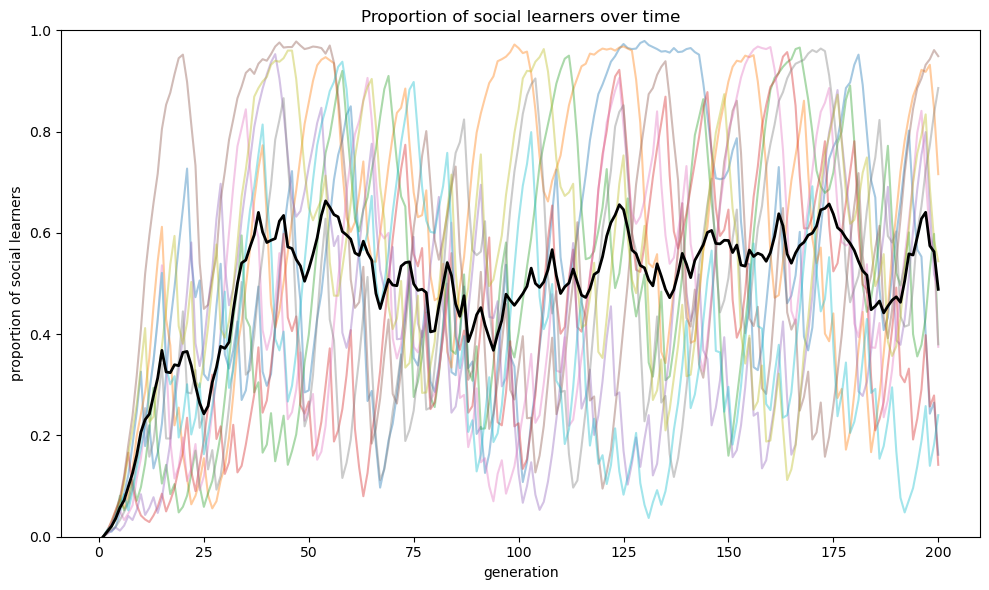

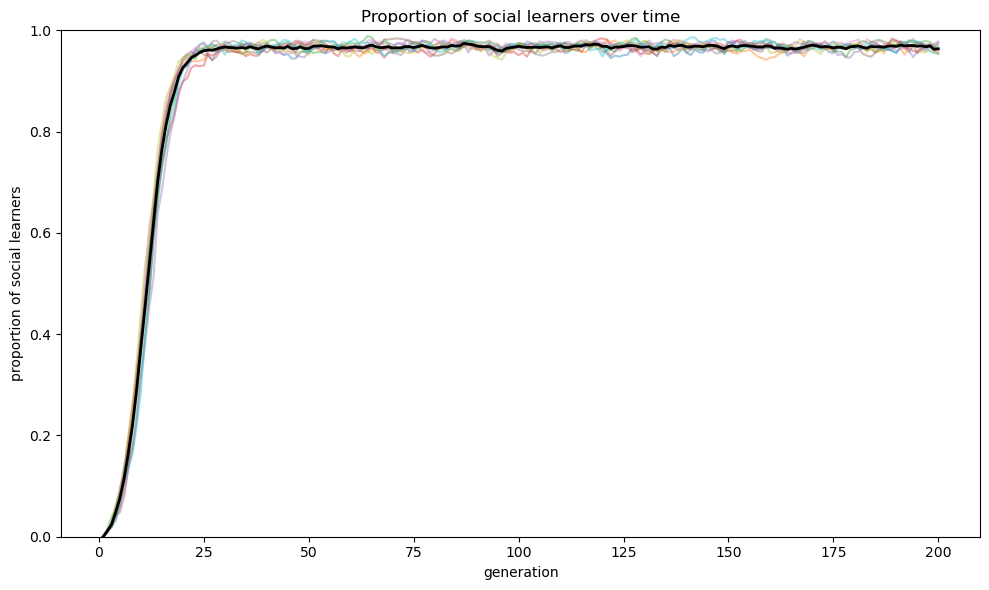

In [36]:
plot_multiple_runs_p_SL(data_model_environmental_change)
plot_multiple_runs_p_SL(data_model_no_environmental_change)

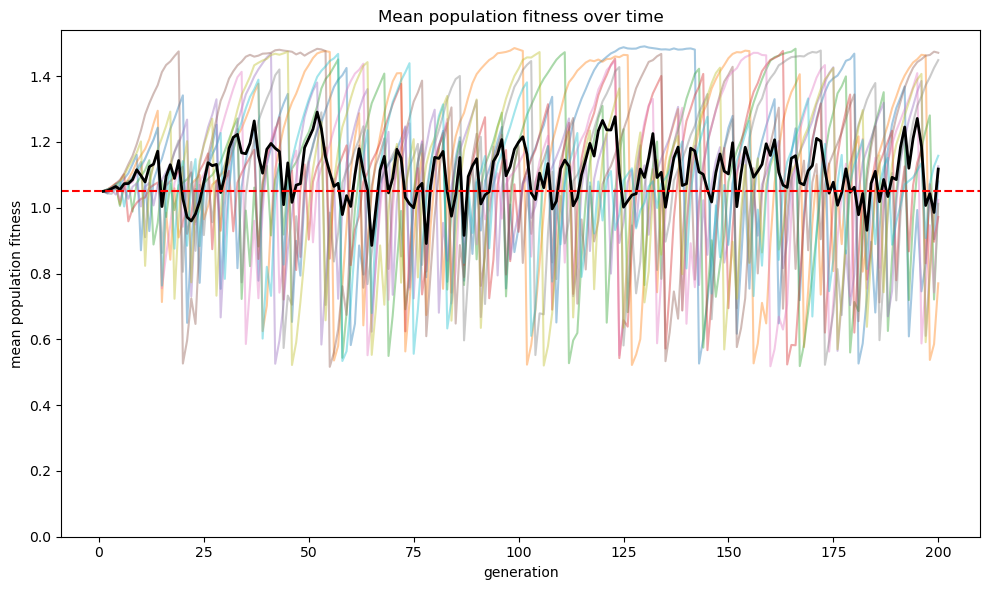

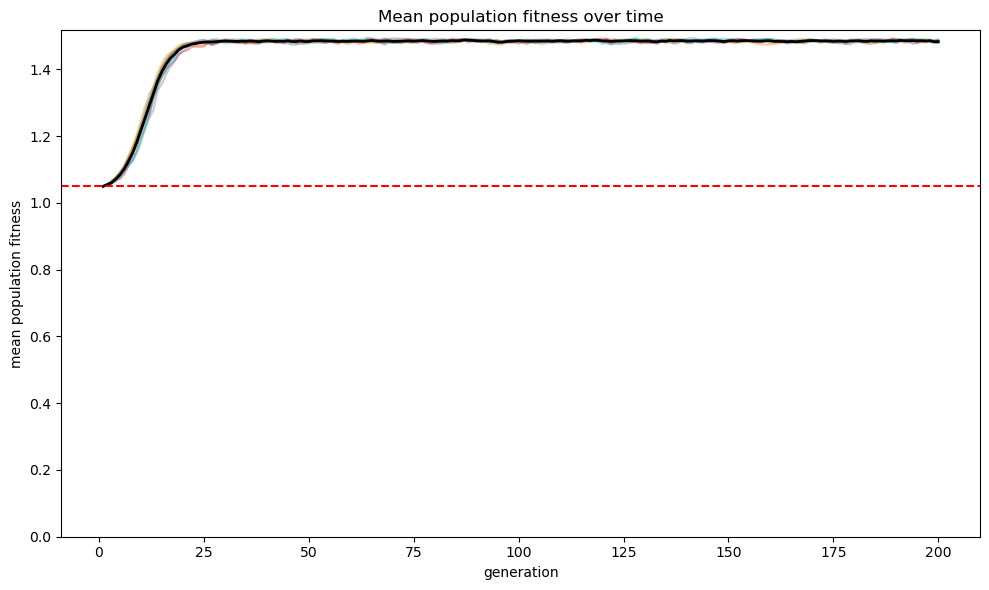

In [37]:
# Here, we can skip the parameters for plot_W because we are using the base value for all of them
plot_W(data_model_environmental_change)
plot_W(data_model_no_environmental_change)

#### Answer

As expected, social learners quicly dominates the population and the population fitness is greater than a population of only individual learners.

Removing environmental change thus resolve Rogers' Paradox (eventhough it's quite unrealistic)!

### 4. Do you think that changing the benefits provided by resources (*b*) would change the evolutionary dynamic of social learning? How?

#### Intuition

This is a tricky question.

Increasing *b* would mean that having the right behavior for the environment is more beneficial. Thus, individual learning should be more beneficial, but socially learning the right behaviour also. I would say that this will results in greater population fitness.

Inversely, decreasing *b* would make individual learning worse. This should then decrease the number of individual learners, and thus increase the number of social learners. I would say that overall it will not change the population fitness.

Let's test those assumption using three model.

In [47]:
data_model_high_b = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

data_model_low_b = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.1,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

data_model_medium_b = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.3,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

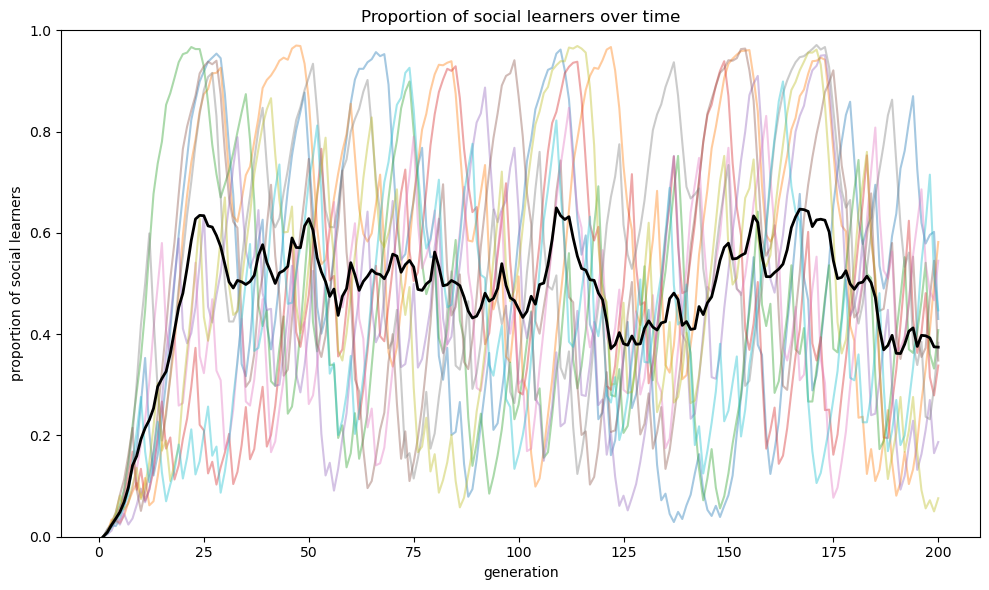

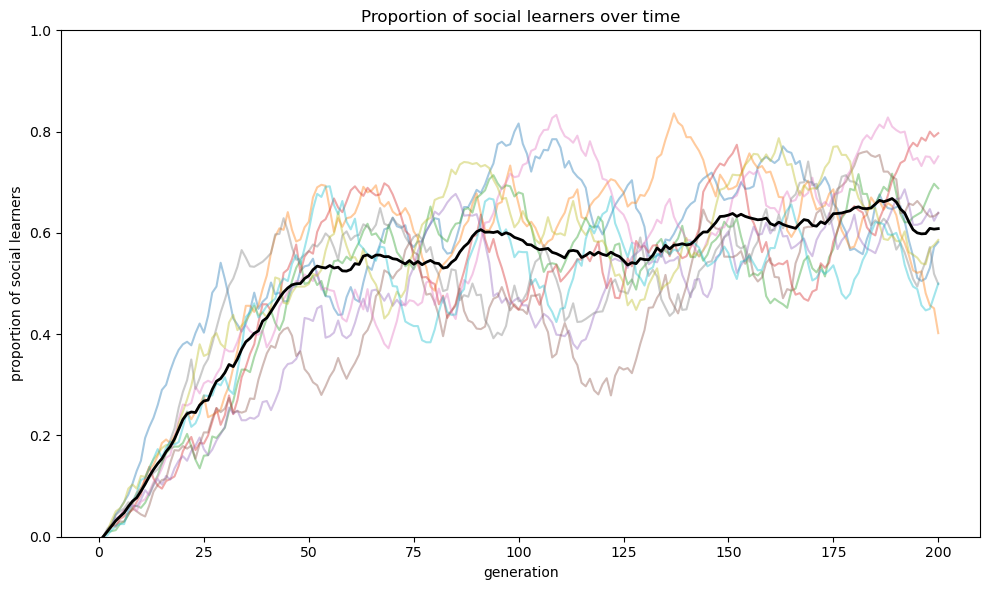

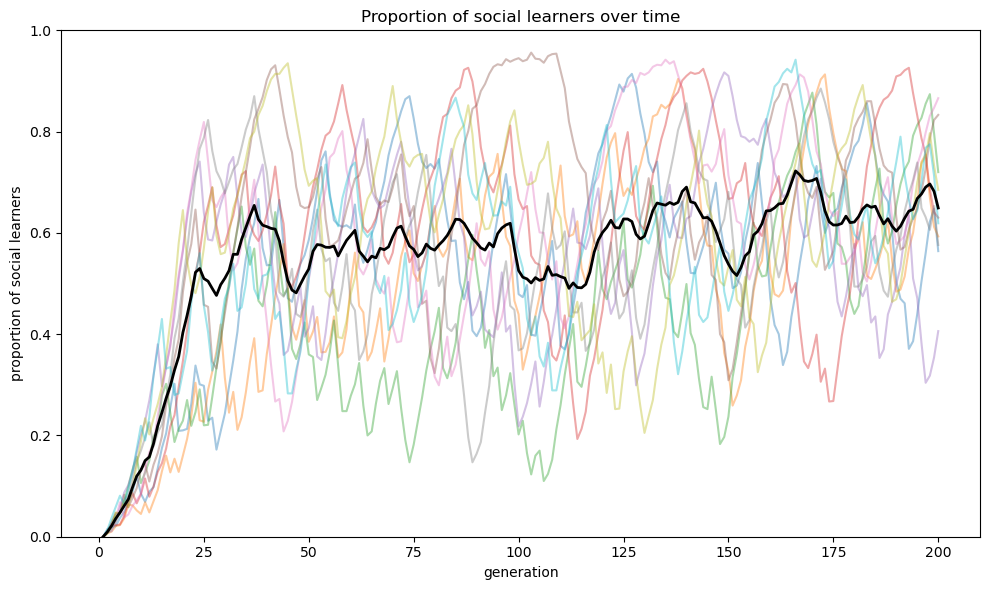

In [48]:
plot_multiple_runs_p_SL(data_model_high_b)
plot_multiple_runs_p_SL(data_model_low_b)
plot_multiple_runs_p_SL(data_model_medium_b)

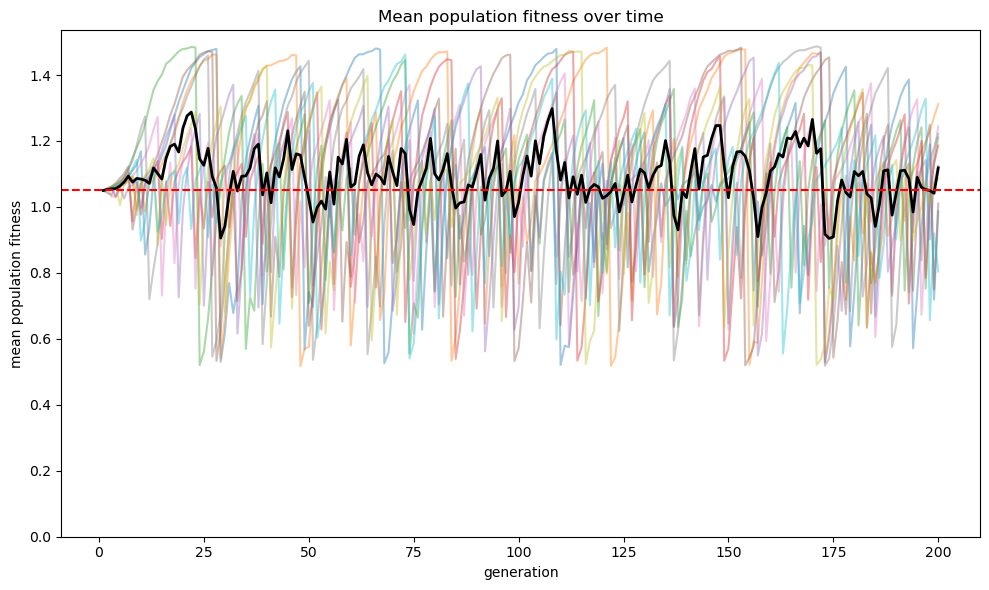

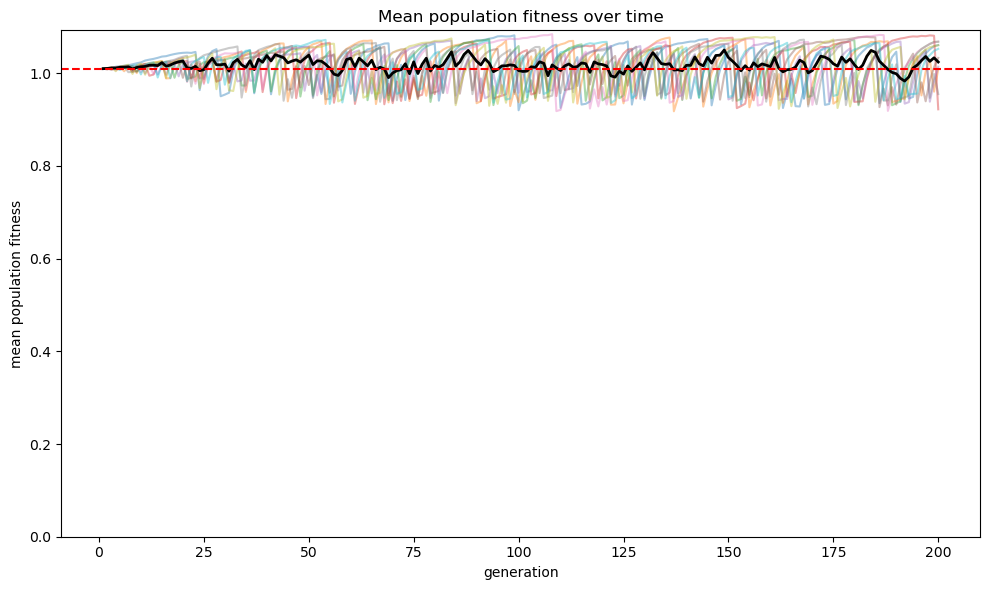

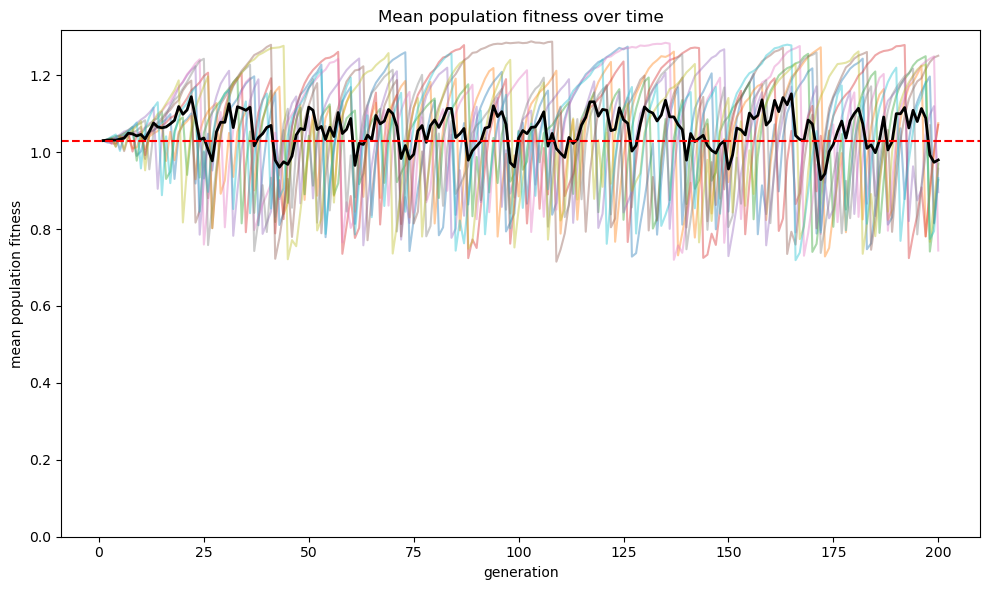

In [49]:
plot_W(data_model_high_b, w=1, b=0.5, c=0.9, p=1)
plot_W(data_model_low_b, w=1, b=0.1, c=0.9, p=1)
plot_W(data_model_medium_b, w=1, b=0.3, c=0.9, p=1)

#### Answer

Our intuitions were wrong.

Changing the benefit of *b* doesn't change the proportion of social learner or the fitness of the population. This means that changing *b* actually benefit both type of learners.

However, we notice that the proportion of social learner as well as the fitness of the population has less variance. Indeed, lowering *b* means that the benefit of being right is smaller. Thus, the difference between a social learner and an individual learner is also smaller. This makes the selection pressure smaller. With less pressure, the change in strategies are less frequent because they matter less. This then makes for less variation of strategies and fitness.

This is a very inuititive results of the model, I suggest you take time trying to wrap your head around it.

### 5. The social learning strategy invades the population because of *s* (cost of social learning) is inferior to *c* (cost of individual learning). But does the success of social learning strategy depend only on the relative cost of *s* relative to *c*, or also on the *absolute* cost of both types of learning?

#### Intuition

First, we just saw in 4 than low benefit for both type of learners (i.e., absolute low value) lead to weak selection pressure, and thus less variation in the population. Inversely, we might think that larger absolute values will lead to greater selection. However, with high cost for both learning, learning will lost its fitness advantage overall and lead to low population fitness with results similar to no learning (i.e., a lot of social leaner learning outdated behavior).

For the relative cost, having s < c allows for the invasion of social learning. The greater this difference, the easier it will be for social learning to invade.

Here, we have two hypothesis. We need to cross our parameter values to test every combination. This it typical of modeling work where you want not only to test the effect of one of your parameter on the results but also the interactions between parameters. As you increase the number of parameters of your model, you might get a more "realistic" model of the world, but you will be faced with the curse of dimensionality (https://en.wikipedia.org/wiki/Curse_of_dimensionality), making your post-hoc analysis of the model almost impossible.

Our parameter combinations will thus be:

| Absolute cost | Relative cost | *c* | *s* |
| --------------| ------------- | --- | --- |
| Low | Low | 0.9 | 0.8 |
| Low | High | 0.9 | 0 |
| High | Low | 9 | 8 |
| High | High | 9 | 0 |

Note that because of Rogers' model implementation, we have to reduce *b* with high absolute cost for the model to run.

In [60]:
data_model_low_low = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.05,
    c=0.9,
    s=0.8,
    mu=0.01,
    p=1.0,
    u=0.2
)

data_model_low_high = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.05,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

data_model_high_low = rogers_model(
    N=1000,
    t_max=100,
    r_max=10,
    w=1.0,
    b=0.05,
    c=9,
    s=8,
    mu=0.01,
    p=1.0,
    u=0.2
)

data_model_high_high = rogers_model(
    N=1000,
    t_max=100,
    r_max=10,
    w=1.0,
    b=0.05,
    c=9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

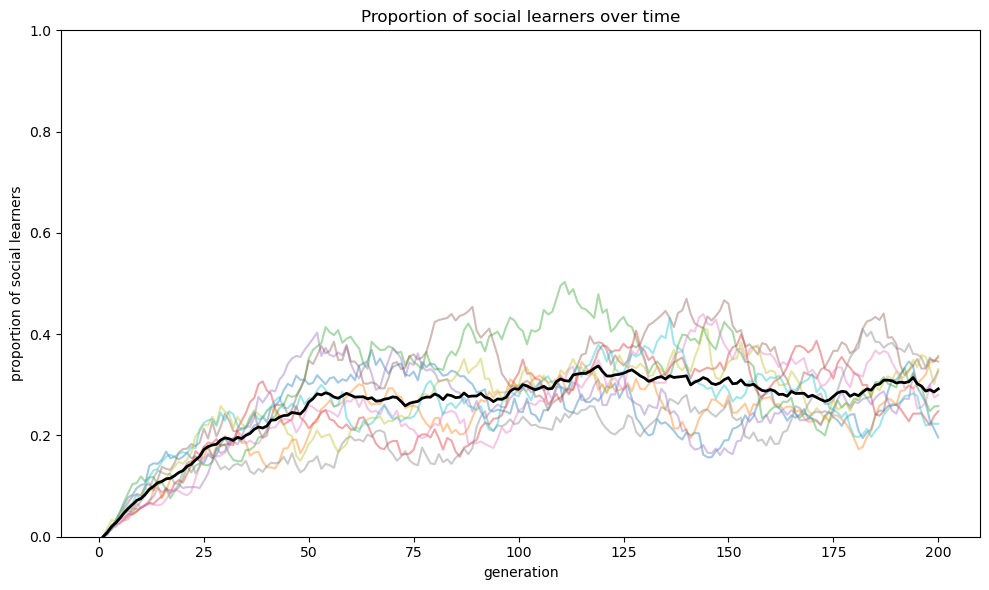

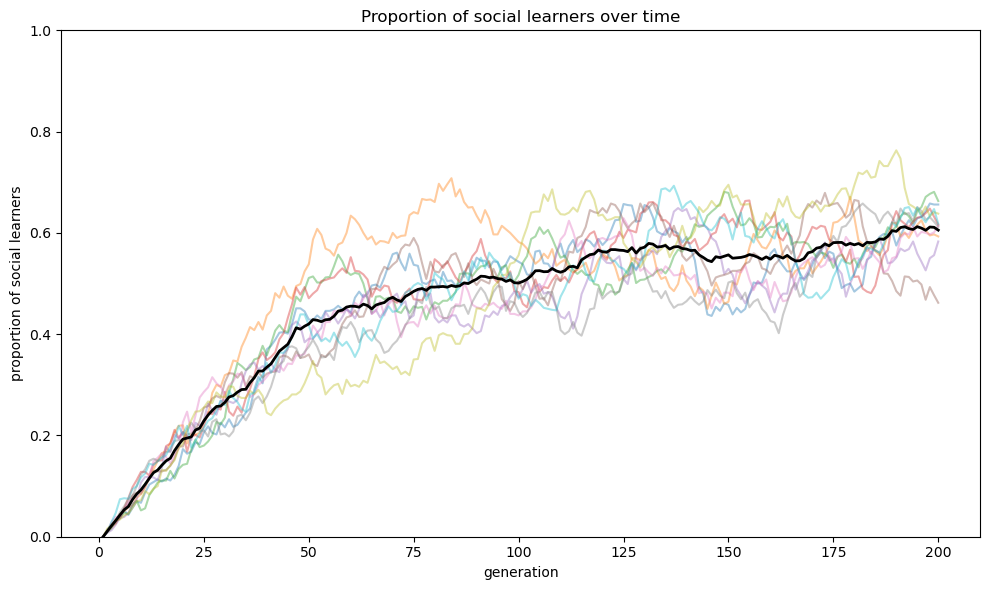

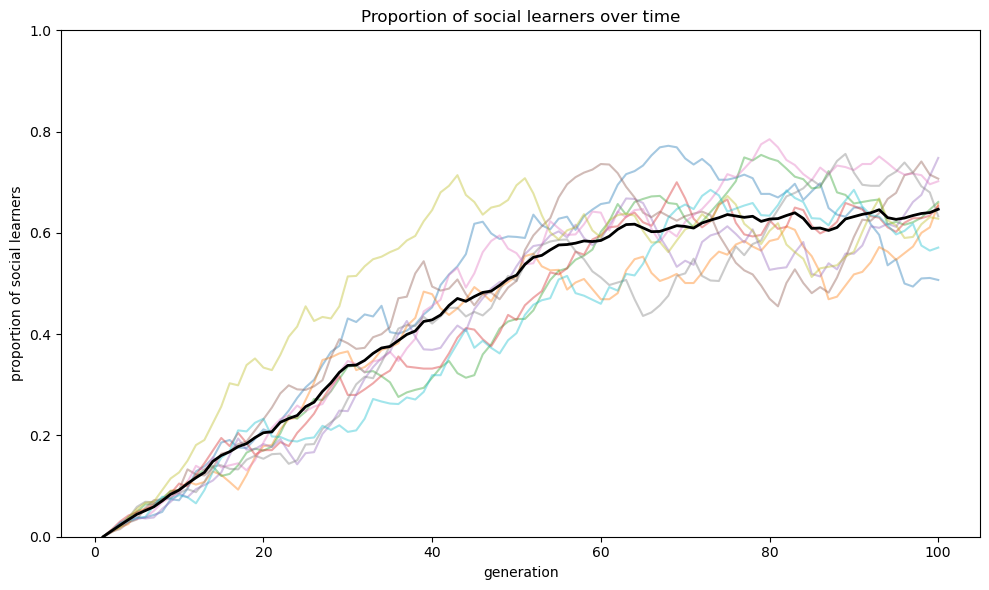

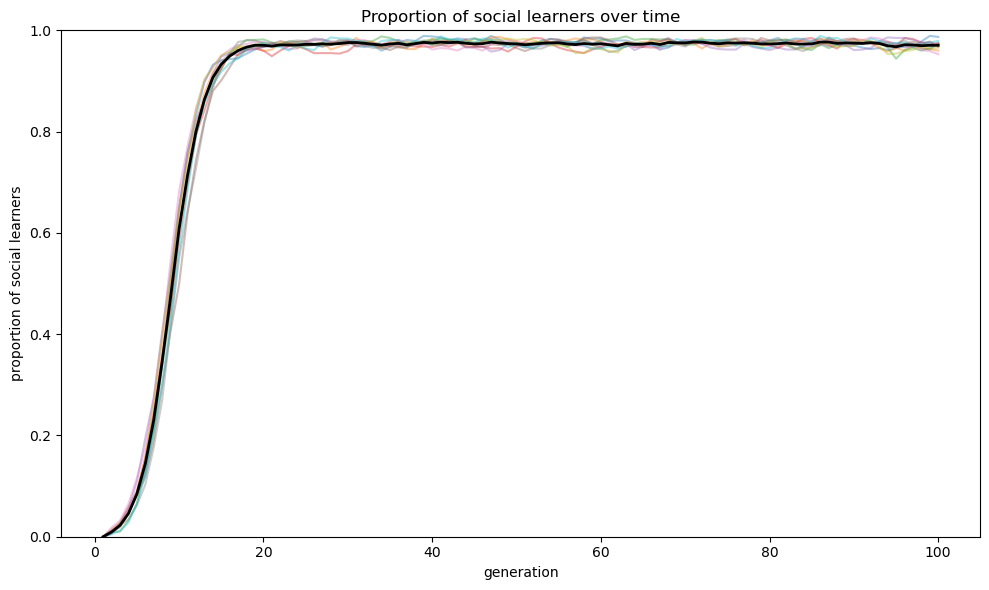

In [61]:
plot_multiple_runs_p_SL(data_model_low_low)
plot_multiple_runs_p_SL(data_model_low_high)
plot_multiple_runs_p_SL(data_model_high_low)
plot_multiple_runs_p_SL(data_model_high_high)

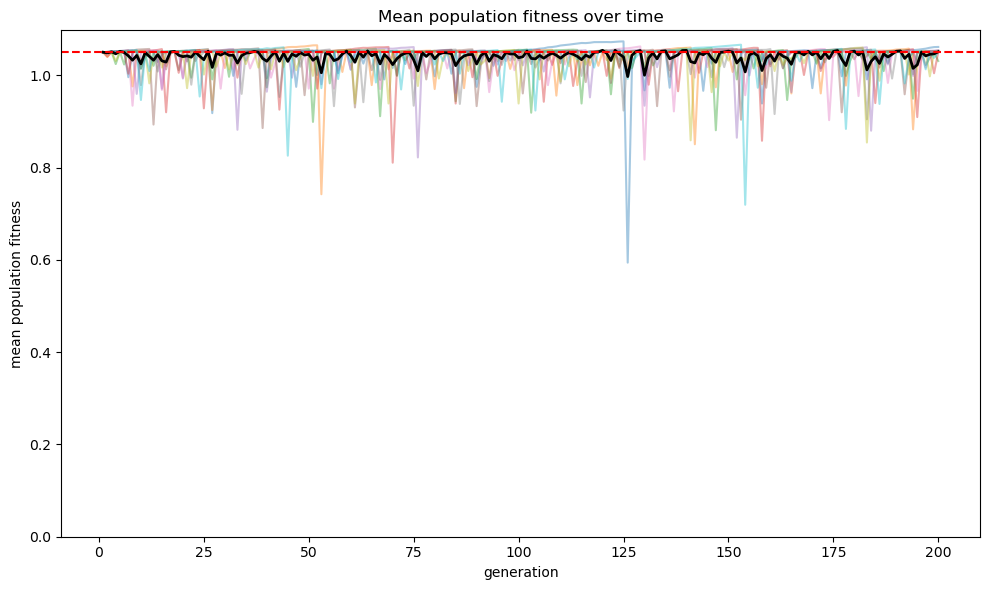

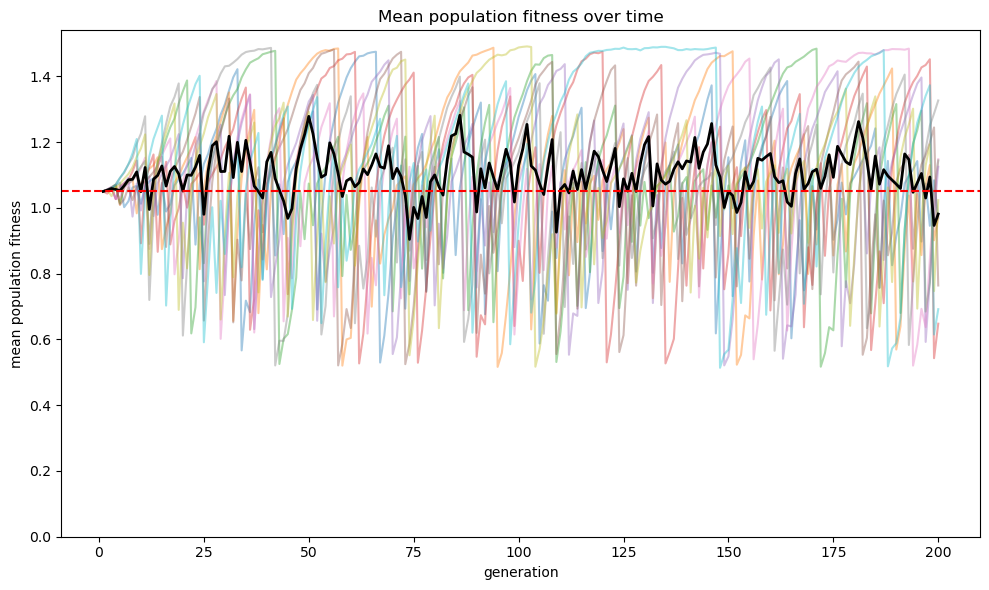

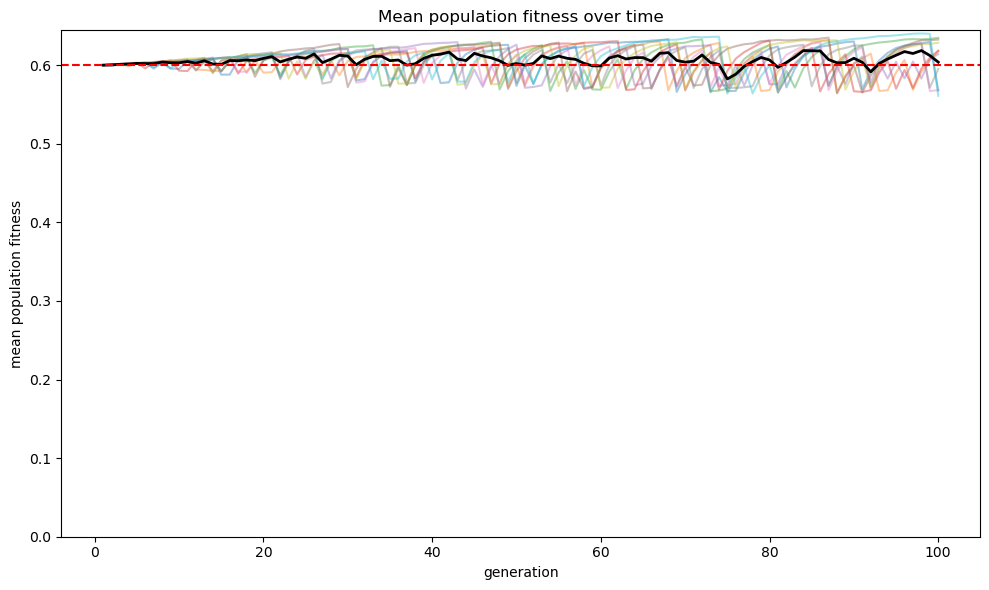

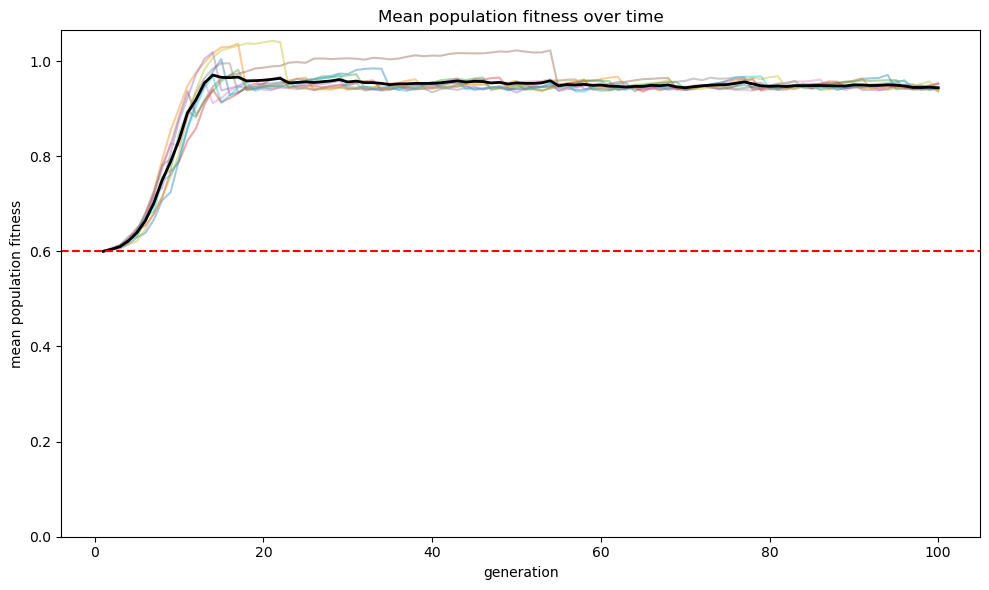

In [59]:
plot_W(data_model_low_low, w=1, b=0.5, c=0.9, p=1)
plot_W(data_model_low_high, w=1, b=0.5, c=0.9, p=1)
plot_W(data_model_high_low, w=1, b=0.05, c=9, p=1)
plot_W(data_model_high_high, w=1, b=0.05, c=9, p=1)

#### Answer

First, what jumps to the eye is that high absolute & relative cost leads to a population mainly composed of social learner with a population fitness above that of an individual learner population. This is exactly the smae results as question 4.

Second, we notice that high relative cost lead to an invasion of social learning (figure 2&4) greater than lower relative cost. This is in line with the idea that relative cost determines how much the social learning population will invade.

Third, high absolute cost reduces the fitness of the population a lot. Indeed, higher cost for similar benefits (*b* is ketp the same) intuitively leads to less fitness.

Overall, the interaction shows that the selection depends on both: relative cost determines the invasion of social learning, and absolute cost determine the strength of said selection and the fitness of the population.